# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [18]:
!python3 -m pip install scikit-learn -U

    100% |████████████████████████████████| 6.9MB 3.9MB/s eta 0:00:01  1% |▋                               | 122kB 4.4MB/s eta 0:00:02    29% |█████████▍                      | 2.0MB 18.9MB/s eta 0:00:01    81% |██████████████████████████▏     | 5.6MB 32.0MB/s eta 0:00:01
    100% |████████████████████████████████| 20.1MB 1.6MB/s eta 0:00:01  7% |██▍                             | 1.5MB 23.4MB/s eta 0:00:01    21% |██████▉                         | 4.3MB 26.0MB/s eta 0:00:01    28% |█████████▎                      | 5.8MB 32.6MB/s eta 0:00:01    42% |█████████████▋                  | 8.6MB 26.6MB/s eta 0:00:01    60% |███████████████████▍            | 12.2MB 28.1MB/s eta 0:00:01    73% |███████████████████████▌        | 14.8MB 28.2MB/s eta 0:00:01    85% |███████████████████████████▎    | 17.2MB 24.1MB/s eta 0:00:01    91% |█████████████████████████████▎  | 18.4MB 28.5MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existin

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import tqdm
import numpy as np
import time 

# Tokenisation/Lemmatisation
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')  # Lemmatisation
from nltk.stem.porter import PorterStemmer      # Stemming
from nltk.stem.wordnet import WordNetLemmatizer # Lemmatising

# Classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from IPython.display import Audio
sound_file = 'https://www.shockwave-sound.com/sound-effects/windchimes-sounds/campanas.wav'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def results(pipeline, X_test, Y_test):

    Y_pred = pipeline.predict(X_test)
    # Turn into dataframe and label correctly
    columns = Y_test.columns
    df_Y_pred = pd.DataFrame(Y_pred, columns = columns)
    df_Y_pred.index = Y_test.index
    print('accuracy %0.2f' % accuracy_score(df_Y_pred, Y_test))
    print('f1_score %0.2f' % f1_score(df_Y_pred, Y_test, average='weighted'))
    print('f1_score+1 %0.2f' % f1_score(df_Y_pred+1, Y_test+1, average='weighted'))

    print('duration of fit: %0.2fs' % duration)
    print(classification_report(Y_test,df_Y_pred, target_names = columns))

In [3]:
# load data from database
engine = create_engine('sqlite:///disaster_response.db')
df = pd.read_sql_table('disaster_response', con=engine)

In [4]:
# Split features and labels
X = df['message']
Y = df.iloc[:,3:]

### 2. Write a tokenization function to process your text data

In [47]:
def tokenize(text):
    # lowercase, remove punc
    tokens = re.sub(r'[^a-zA-Z0-9]',' ',text.lower())
    # Split (and don't remove stopwords)
    #tokens = [w for w in word_tokenize(tokens) if w not in stopwords.words("english")]
    tokens = word_tokenize(tokens) # Without stopword removal
    # Stem
    tokens = [PorterStemmer().stem(t) for t in tokens]
    # Lemmatise nouns
    tokens = [WordNetLemmatizer().lemmatize(t) for t in tokens]
    # Lemmatise verbs
    tokens = [WordNetLemmatizer().lemmatize(t, pos='v').strip() for t in tokens]
    return tokens

In [48]:
for x in X.iloc[:10]:
    print(tokenize(x))

['weather', 'updat', 'a', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pas', 'over', 'haiti']
['be', 'the', 'hurrican', 'over', 'or', 'be', 'it', 'not', 'over']
['look', 'for', 'someon', 'but', 'no', 'name']
['un', 'report', 'leogan', '80', '90', 'destroy', 'onli', 'hospit', 'st', 'croix', 'function', 'need', 'suppli', 'desper']
['say', 'west', 'side', 'of', 'haiti', 'rest', 'of', 'the', 'countri', 'today', 'and', 'tonight']
['inform', 'about', 'the', 'nation', 'palac']
['storm', 'at', 'sacr', 'heart', 'of', 'jesu']
['plea', 'we', 'need', 'tent', 'and', 'water', 'we', 'be', 'in', 'silo', 'thank', 'you']
['i', 'would', 'like', 'to', 'receiv', 'the', 'messag', 'thank', 'you']
['i', 'be', 'in', 'croix', 'de', 'bouquet', 'we', 'have', 'health', 'issu', 'they', 'worker', 'be', 'in', 'santo', '15', 'an', 'area', 'in', 'croix', 'de', 'bouquet']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [43]:
# build pipeline
pipeline1 = Pipeline([('vect1', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf1', TfidfTransformer()),
                     ('clf1', MultiOutputClassifier(RandomForestClassifier()))
                    ])

pipeline2 = Pipeline([('vect2', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf2', TfidfTransformer()),
                     ('clf2', MultiOutputClassifier(MultinomialNB()))
                    ])

pipeline3 = Pipeline([('vect3', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf3', TfidfTransformer()),
                     ('clf3', MultiOutputClassifier(LogisticRegression()))
                    ])

pipeline4 = Pipeline([('vect4', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf4', TfidfTransformer()),
                     ('clf4', MultiOutputClassifier(SGDClassifier()))
                    ])

# Choose pipeline to use
pipeline = pipeline4

In [8]:
pipeline.steps

[('vect4',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=<function tokenize at 0x7fbc78130620>, vocabulary=None)),
 ('tfidf4',
  TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('clf4',
  MultiOutputClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
         eta0=0.0, fit_intercept=True, l1_ratio=0.15,
         learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
         n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
         shuffle=True, tol=None, verbose=0, warm_start=False),
             n_jobs=1))]

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [123]:
# Fit model

start = time.time()
pipeline.fit(X_train, Y_train)
duration = time.time() - start

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [127]:
results(pipeline, X_test, Y_test)

# Play completion sound
Audio(sound_file, autoplay=True)
# for column in columns:
#     print(column, classification_report(Y_test[column],df_Y_pred[column]))

accuracy 0.29
f1_score 0.76
duration of fit: 30.11s
                        precision    recall  f1-score   support

               related       0.85      0.95      0.90      5050
               request       0.80      0.57      0.66      1121
                 offer       0.00      0.00      0.00        28
           aid_related       0.78      0.66      0.72      2745
          medical_help       0.68      0.15      0.24       526
      medical_products       0.75      0.18      0.29       335
     search_and_rescue       0.76      0.12      0.21       180
              security       0.00      0.00      0.00       128
              military       0.80      0.16      0.26       231
                 water       0.79      0.62      0.69       456
                  food       0.81      0.71      0.76       746
               shelter       0.82      0.50      0.62       543
              clothing       0.71      0.46      0.56       112
                 money       0.75      0.02      0.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| Scenario | accuracy* | precision  |  recall | f1-score  | support | fit-time (secs) |
|---|---|---|---|---|---|---|
| *First 1000 rows of input:* **Random Forest Classifier** | - | 0.69 | 0.60 | 0.61 | 1005 | - |
|*All:* **Random Forest Classifier**| 0.25 | 0.76    |  0.50  |    0.54 |    20925 |- |
|**MultinomialNB**|   0.17 |  0.56   |   0.38    |  0.39   |  20711 | - |
|**LogisticRegression**|  0.29 | 0.78     | 0.55  |    0.60   | 20711| 43.44 |
|**SDG**| 0.31 | 0.76  |    0.57  |    0.61  |   20459 | 29.97 |


**\*Accuracy is low, think [this](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) is the reason**

>In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

i.e. it has to get every single label right for each message, which is not necessarily the output we require, as long as it gets some right the classifier can still be useful.

In the example below, the "classifier" gets 14 out of 16 individual predictions correct, but the accuracy is still just 50%.

In [98]:
accuracy_score(np.array([[0, 1,1,1], [1, 1,1,1], [1, 1,1,1], [1, 0,1,1]]), np.ones((4, 4)))

0.5

### 6. Improve your model
Use grid search to find better parameters. 

In [101]:
#pipeline.get_params()

In [11]:
parameters = {
              'clf4__estimator__loss':['hinge', 'log', 'modified_huber'],
              'clf4__estimator__alpha':[0.0001,0.001]
             }

# Tried 'clf4__estimator__max_iter':[1000, 2000], no effect on f1, doubled time, removed

cv = GridSearchCV(pipeline, param_grid=parameters, scoring = 'f1_weighted', verbose = 3)
start = time.time()
cv.fit(X_train, Y_train)
duration = time.time() - start

print(duration)
print(cv.best_params_)
results(cv, X_test, Y_test)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=hinge ......


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=hinge, score=0.6233520806142819, total=  29.7s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=hinge ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.4s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=hinge, score=0.6160845191690465, total=  29.7s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=hinge ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=hinge, score=0.620591784737377, total=  29.7s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=log ........


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=log, score=0.578052632844271, total=  30.2s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=log ........


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=log, score=0.561497550159179, total=  30.1s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=log ........


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=log, score=0.5684696810117027, total=  30.2s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=modified_huber 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=modified_huber, score=0.6487691466561224, total=  30.2s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=modified_huber 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=modified_huber, score=0.6410145650349508, total=  29.8s
[CV] clf4__estimator__alpha=0.0001, clf4__estimator__loss=modified_huber 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.0001, clf4__estimator__loss=modified_huber, score=0.6424494133351294, total=  29.7s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=hinge .......


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=hinge, score=0.4664518683120885, total=  29.9s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=hinge .......


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=hinge, score=0.45918478501127, total=  29.8s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=hinge .......


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=hinge, score=0.4586105346844678, total=  29.7s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=log .........


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=log, score=0.39712729669191144, total=  30.2s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=log .........


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=log, score=0.38879595140653433, total=  30.0s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=log .........


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=log, score=0.3929740142121182, total=  33.5s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=modified_huber 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=modified_huber, score=0.5751566516426188, total=  32.9s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=modified_huber 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=modified_huber, score=0.5650446101843684, total=  29.8s
[CV] clf4__estimator__alpha=0.001, clf4__estimator__loss=modified_huber 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

[CV]  clf4__estimator__alpha=0.001, clf4__estimator__loss=modified_huber, score=0.5735898962423552, total=  30.5s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 15.0min finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3."

930.7740185260773
{'clf4__estimator__alpha': 0.0001, 'clf4__estimator__loss': 'modified_huber'}
accuracy 0.30
f1_score 0.73
duration of fit: 930.77s
                        precision    recall  f1-score   support

               related       0.87      0.91      0.89      4964
               request       0.79      0.57      0.66      1102
                 offer       0.00      0.00      0.00        26
           aid_related       0.74      0.71      0.73      2714
          medical_help       0.62      0.31      0.41       513
      medical_products       0.62      0.30      0.41       338
     search_and_rescue       0.71      0.17      0.28       185
              security       0.00      0.00      0.00       116
              military       0.69      0.33      0.44       213
                 water       0.79      0.56      0.65       420
                  food       0.83      0.72      0.77       727
               shelter       0.75      0.55      0.63       580
              clot

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
results(cv, X_test, Y_test)

accuracy 0.30
f1_score 0.73
duration of fit: 930.77s
                        precision    recall  f1-score   support

               related       0.87      0.91      0.89      4964
               request       0.79      0.57      0.66      1102
                 offer       0.00      0.00      0.00        26
           aid_related       0.74      0.71      0.73      2714
          medical_help       0.62      0.31      0.41       513
      medical_products       0.62      0.30      0.41       338
     search_and_rescue       0.71      0.17      0.28       185
              security       0.00      0.00      0.00       116
              military       0.69      0.33      0.44       213
                 water       0.79      0.56      0.65       420
                  food       0.83      0.72      0.77       727
               shelter       0.75      0.55      0.63       580
              clothing       0.79      0.55      0.65        96
                 money       0.56      0.30      0

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
Audio(sound_file, autoplay=True)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [49]:
pipeline5 = Pipeline([('vect4', CountVectorizer(tokenizer=tokenize)),
                     ('tfidf4', TfidfTransformer()),
                     ('clf4', MultiOutputClassifier(SGDClassifier(loss ='modified_huber')))
                    ])

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Fit model
start = time.time()
pipeline5.fit(X_train, Y_train)
duration = time.time() - start

In [73]:
#Y_pred = pipeline5.predict(X_test)
# Turn into dataframe and label correctly
columns = Y_test.columns
#df_Y_pred = pd.DataFrame(Y_pred, columns = columns)
#df_Y_pred.index = Y_test.index
print('accuracy %0.2f' % accuracy_score(Y_pred, Y_test))
print('f1_score %0.2f' % f1_score(Y_pred, Y_test, average='weighted'))
print('duration of fit: %0.2fs' % duration)
print(classification_report(Y_test,Y_pred, target_names = columns))

accuracy 0.09
f1_score 0.40
duration of fit: 30.89s
                        precision    recall  f1-score   support

               related       0.77      0.82      0.79      5011
               request       0.16      0.12      0.14      1112
                 offer       0.00      0.00      0.00        33
           aid_related       0.42      0.41      0.41      2718
          medical_help       0.11      0.05      0.07       518
      medical_products       0.05      0.02      0.03       343
     search_and_rescue       0.02      0.01      0.01       183
              security       0.00      0.00      0.00       107
              military       0.06      0.03      0.04       202
                 water       0.06      0.05      0.06       417
                  food       0.10      0.10      0.10       726
               shelter       0.08      0.07      0.07       577
              clothing       0.02      0.01      0.01        96
                 money       0.00      0.00      0.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print(f1_score(df_Y_pred, Y_test, average='micro'))
print(f1_score(df_Y_pred, Y_test, average='macro'))
print(f1_score(df_Y_pred, Y_test, average='weighted'))
print(f1_score(df_Y_pred, Y_test, average='samples'))

0.346773098748337
0.07637793356135547
0.3988216736590946
0.29975173042446024


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


#### Difference in the weighted f1_scores:

Detail [here](https://stackoverflow.com/questions/60535642/why-is-the-weighted-average-f1-score-from-sklearns-classification-report-diffe)

> The F1 score i.e. the F1 score for the positive class in a binary classification model. And this is calculated as the F1 = 2 * ((p * r)/(p+r)
>
>The weighted F1 score is a special case where we report not only the score of positive class, but also the negative class. This is important where we have imbalanced classes. Because the simple F1 score gives a good value even if our model predicts positives all the times.
>
>So the weighted average takes into account the number of samples of both the classes as well and can't be calculated by the formula you mentioned above.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF
* **Try removing stopwords** - *Reduced the F1_score to 0.40!!*
* **Try introducing genre, with a Feature Union on a dummy variable**

### 9. Export your model as a pickle file

In [64]:
import pickle

with open('picked_model', 'wb') as f:
    pickle.dump( pipeline5, f)


    

In [70]:
with open('picked_model', 'rb') as f:
    clf2 = pickle.load(f)


In [71]:
clf2.predict(X_test)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [96]:
data = df.sum(axis=0, numeric_only = True).sort_values()

In [112]:
data

offer                       118
shops                       120
tools                       159
fire                        282
hospitals                   283
missing_people              298
aid_centers                 309
clothing                    405
security                    471
cold                        530
electricity                 532
money                       604
search_and_rescue           724
military                    860
refugees                    875
other_infrastructure       1151
death                      1194
transport                  1201
medical_products           1313
buildings                  1333
other_weather              1376
water                      1672
infrastructure_related     1705
medical_help               2084
floods                     2155
shelter                    2314
storm                      2443
earthquake                 2455
food                       2923
other_aid                  3446
request                    4474
direct_r

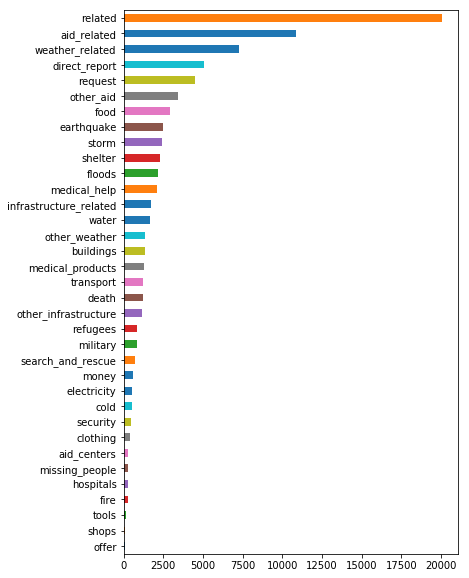

In [109]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (6,10))
data.plot(kind='barh', ax =ax);


(26214, 38)